# notebook that downloads and processes data

## What factors could be a good predictors for S&P 500 returns?
Notes:
The goal is to download different data that could potentially predict S&P 500 returns, then choose a model (machine learning methods like SVM, decisiontree, randomforest, maybe even neural network) and see whether it is a good predictor or not. Output should be a summary of the input, some visualization and some summary statistics.

Data that could be used as input:
Inflation data
Interest rates
GDP growth
Unemployment data
Exchange rates
Investor sentiment (how is this measured?)
Earnings estimates
Dividend yield
gold price

Things to consider: Data frequency


In [98]:
#Import needed packages
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#To plot pretty figures 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Import our data
log_returns_currencies = pd.read_csv("../data/processed/log_returns_currency_data.csv")
log_returns_spx = pd.read_csv("../data/processed/log_returns_spx_data.csv")
dataframe = pd.merge(log_returns_currencies, log_returns_spx.iloc[1:], on='DATE', how='inner')
print(dataframe)

            DATE   USDEUR   USDJPY   USDGBP   USDCHF   USDAUD   USDCAD  \
0     2013-11-05  0.00341  0.00020 -0.00588 -0.00219  0.00242 -0.00316   
1     2013-11-06 -0.00444  0.00000 -0.00224  0.00186 -0.00326  0.00278   
2     2013-11-07  0.01040  0.00041  0.00068 -0.00820  0.00516 -0.00221   
3     2013-11-08  0.00247 -0.00476  0.00462 -0.00391  0.00934 -0.00430   
4     2013-11-12 -0.00530 -0.00624  0.00495  0.00478  0.00975 -0.00133   
...          ...      ...      ...      ...      ...      ...      ...   
2478  2023-10-23 -0.00509  0.00047 -0.00672 -0.00011 -0.00284  0.00117   
2479  2023-10-24  0.00480 -0.00040  0.00533 -0.00179 -0.00189 -0.00496   
2480  2023-10-25  0.00113 -0.00067  0.00247 -0.00179  0.00237 -0.00204   
2481  2023-10-26  0.00483 -0.00333  0.00223 -0.00490  0.00348 -0.00420   
2482  2023-10-27 -0.00568  0.00560 -0.00313 -0.00289 -0.00632 -0.00260   

       USDNZD   USDSEK   USDSGD   USDNOK    SP500  
0    -0.00133 -0.00402 -0.00064 -0.00557 -0.00281  
1    -0

Ideas, make lag some kind of parameter you can tweak in shine, same with the test_size (how large test and training sets are respectively)

In [96]:
#Here we compute S&P returns from the log returns in order to classify them as positive or negative
#Then we split the dataset into a training set and a test-set, we also create a lag to make predictions
lag = 1
y1 = dataframe.iloc[lag:,11] #Account for the lag time for response variable
y_dates = dataframe.iloc[lag:,0] #Dates of response variable
X1 = dataframe.iloc[:-lag,1:11] #Account for the lag time for regressor variable
x1_spx = dataframe.iloc[:-lag,11] #S&P 500 accounted for lag as a regressor variable
X_dates = dataframe.iloc[:-lag:,0] #Dates of regressor variables
y1_exp = np.exp(y1) - 1
y1_binary = (y1_exp > 0).astype(int)
#Here we create two sets of training and test sets, one with only currencies as regressors [1], and one with
#also S&P 500 as a regressor [2]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1_binary, random_state=42, shuffle=False, test_size=0.25)
X2_train, X2_test, y2_train, y2_test = train_test_split(pd.concat([X1, x1_spx], axis=1), y1_binary, random_state=42, shuffle=False, test_size=0.25)
y_test_dates = y_dates[y1_test.index[0]-1:]

1862    2021-05-04
1863    2021-05-05
1864    2021-05-06
1865    2021-05-07
1866    2021-05-10
           ...    
2478    2023-10-23
2479    2023-10-24
2480    2023-10-25
2481    2023-10-26
2482    2023-10-27
Name: DATE, Length: 621, dtype: object


In [79]:
#Support Vector Classification SVC without S&P500 as explanatory variable
svc1_clf = SVC(kernel="rbf", random_state=42)
svc1_clf.fit(X1_train, y1_train)
y1_pred_train_svc = svc1_clf.predict(X1_train)
y1_pred_test_svc = svc1_clf.predict(X1_test)
#Support Vector Classification SVC with S&P500 as explanatory variable
svc2_clf = SVC(kernel="rbf", random_state=42)
svc2_clf.fit(X2_train, y2_train)
y2_pred_train_svc = svc2_clf.predict(X2_train)
y2_pred_test_svc = svc2_clf.predict(X2_test)

In [80]:
#@title Change all 0 to -1 for return calculation
y1_pred_test_svc[np.where(y1_pred_test_scv==0)] = -1

y2_pred_test_svc[np.where(y2_pred_test_svc == 0)] = -1

y1_ret = y1_exp

In [87]:
y_bench = y1_ret[y1_test.index[0]-lag:]  # S&P500 Performance starting at test date holding Long Strategy
y_long = np.cumsum(y_bench)  # Performance Long
y_svc1 = np.cumsum(y_bench * y1_pred_test_svc)  # Performance Random Forest without S&P500 as regressor
y_svc2 = np.cumsum(y_bench * y2_pred_test_svc) #Performance Random Forest with S&P500 as regressor


1       1
2       0
3       1
4       0
5       1
       ..
2478    0
2479    1
2480    0
2481    0
2482    0
Name: SP500, Length: 2482, dtype: int64


In [82]:
#@title Classifiers Accuracies 
accuracies = pd.DataFrame({"Classifiers": ["SVC"],
                           "in sample": [accuracy_score(y2_train, y2_pred_train_svc)],
                           "out of sample": [accuracy_score(y2_test, y2_pred_test_svc)]}).set_index('Classifiers')

print(accuracies)

             in sample  out of sample
Classifiers                          
SVC           0.619559       0.404187


621


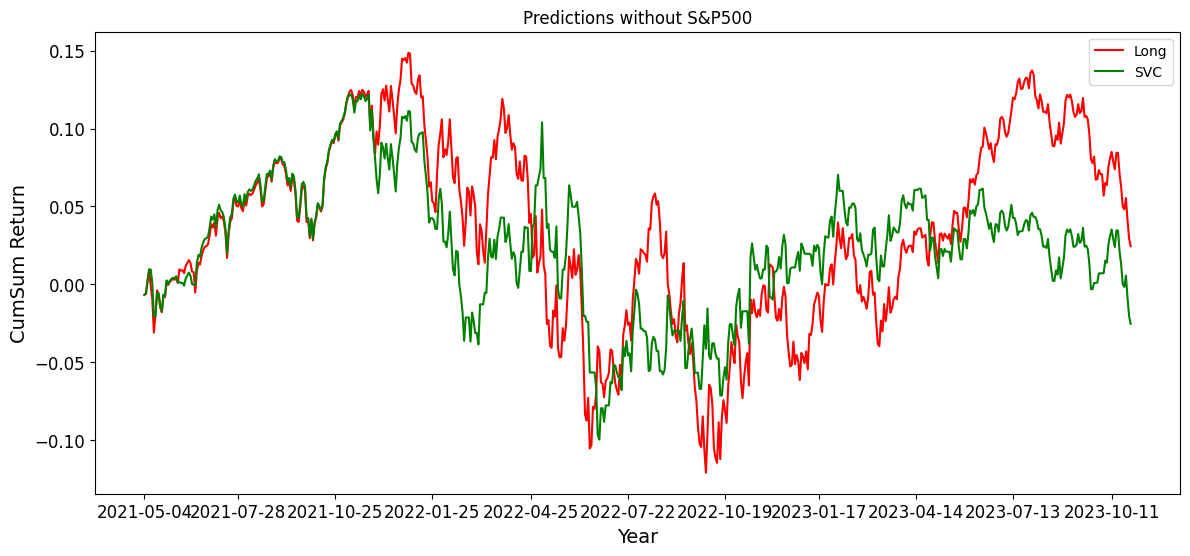

In [99]:
#@title Predictions without S&P500 Classifiers Plot
plt.figure(figsize=(14, 6))
test_perform = pd.DataFrame({"Long":y_long, "SVC": y_svc1})
print(len(y_long))
plt.plot(y_test_dates,test_perform["Long"], "r", label = "Long")
plt.plot(y_test_dates, test_perform["SVC"], "g", label = "SVC")
# Use AutoDateLocator for automatic date tick adjustment
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.title("Predictions without S&P500")
plt.xlabel('Year')
plt.ylabel('CumSum Return')
plt.savefig('classifier.svg', dpi = 1000)
plt.show()